In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [2]:
# Set folder path
data_folder = Path("task3_dataset/")
vibration_folder = Path(data_folder/"vibrationdata/")

# Set file paths
prod_log_path = data_folder / "production_log.csv"
prod_qual_path = data_folder / "product_quality_log.csv"

# Read production log and quality log files
df_prod_log = pd.read_csv(prod_log_path, index_col = 0)
df_qual_log = pd.read_csv(prod_qual_path, index_col = 0)

# Convert the timestamp format for uniformity
df_prod_log['timestamp'] = pd.to_datetime(df_prod_log['timestamp'], format = '%Y-%m-%d_%H-%M-%S')


In [27]:
display(df_prod_log)
display(df_qual_log)

,timestamp,product_id
0,2021-05-17 08:12:48,P3.2.500
1,2021-05-17 08:12:51,P3.2.501
2,2021-05-17 08:12:54,P3.2.502
3,2021-05-17 08:12:57,P3.2.503
4,2021-05-17 08:13:00,P3.2.504
...,...,...
1651,2021-05-17 09:35:21,P3.2.2151
1652,2021-05-17 09:35:24,P3.2.2152
1653,2021-05-17 09:35:27,P3.2.2153
1654,2021-05-17 09:35:30,P3.2.2154


,machine_id,product_id,quality
0,Printer F0815,P3.2.500,OK
1,Printer F0815,P3.2.501,OK
2,Printer F0815,P3.2.502,OK
3,Printer F0815,P3.2.503,OK
4,Printer F0815,P3.2.504,OK
...,...,...,...
1651,Printer F0815,P3.2.2151,nOK
1652,Printer F0815,P3.2.2152,nOK
1653,Printer F0815,P3.2.2153,nOK
1654,Printer F0815,P3.2.2154,nOK


In [4]:
# Merging product quality log file data and production log file data. Key = 'product_id'

df_prod_qual = df_prod_log.merge(df_qual_log, on = 'product_id', how = 'inner')
df_prod_qual = df_prod_qual.set_index('timestamp')

In [5]:
display(df_prod_qual)

,product_id,machine_id,quality
timestamp,,,
2021-05-17 08:12:48,P3.2.500,Printer F0815,OK
2021-05-17 08:12:51,P3.2.501,Printer F0815,OK
2021-05-17 08:12:54,P3.2.502,Printer F0815,OK
2021-05-17 08:12:57,P3.2.503,Printer F0815,OK
2021-05-17 08:13:00,P3.2.504,Printer F0815,OK
...,...,...,...
2021-05-17 09:35:21,P3.2.2151,Printer F0815,nOK
2021-05-17 09:35:24,P3.2.2152,Printer F0815,nOK
2021-05-17 09:35:27,P3.2.2153,Printer F0815,nOK


In [6]:
# print(df_prod_qual[df_prod_qual['quality'] == 'OK'].count())
# df_prod_qual[df_prod_qual['quality'] == 'nOK'].count()

In [7]:
#Test code - IGNORE
file = "2021-05-17_08-12-48"
vib_df1 = pd.read_csv(vibration_folder/file, sep = "\t", header = None)
vib_df1.columns = ['Sensor1','Sensor2']

### Feature Extraction/Creation

In [8]:
# Features extracted for each sensor:
# 1.Max 2.Min 3.Mean 4.Standard Deviation 5.Root Mean Square

def extractFeature(df):
    rms_sensor1 = math.sqrt((df['Sensor1'] ** 2).mean())
    rms_sensor2 = math.sqrt((df['Sensor2'] ** 2).mean())
    feature_array = np.array([ df['Sensor1'].max(), df['Sensor2'].max(),df['Sensor1'].min(),df['Sensor2'].min(),df['Sensor1'].mean(), df['Sensor2'].mean(),df['Sensor1'].std(),df['Sensor2'].std(), rms_sensor1, rms_sensor2])
    return feature_array

In [9]:
# Test code- IGNORE
feature_array = extractFeature(vib_df1)
print(feature_array)

[ 0.271       0.254      -0.75       -0.488      -0.11753828 -0.11665913
  0.09280735  0.0794944   0.14975991  0.141168  ]


### Reading vibration data file and creating feature matrix

In [10]:
feature_df = pd.DataFrame([])

for file in os.listdir(vibration_folder):
    vib_data = pd.read_csv(vibration_folder/file, sep = "\t", header = None)
    vib_data.columns = ['Sensor1','Sensor2']

    #Function call to extract features
    feature_array = extractFeature(vib_data)
    vib_df = pd.DataFrame([feature_array])
    
    #Converting string filename to datetime object
    file_datetime = datetime.strptime(str(file), '%Y-%m-%d_%H-%M-%S')
    vib_df.index = [file_datetime]
    
    feature_df = feature_df.append(vib_df)

In [11]:
feature_df.columns = ['S1_max', 'S2_max','S1_min','S2_min','S1_mean','S2_mean','S1_std','S2_std','S1_rms','S2_rms']

In [12]:
df_merged = pd.merge(df_prod_qual, feature_df, left_index = True, right_index = True)

In [13]:
display(df_merged)

,product_id,machine_id,quality,S1_max,S2_max,S1_min,S2_min,S1_mean,S2_mean,S1_std,S2_std,S1_rms,S2_rms
timestamp,,,,,,,,,,,,,
2021-05-17 08:12:48,P3.2.500,Printer F0815,OK,0.271,0.254,-0.750,-0.488,-0.117538,-0.116659,0.092807,0.079494,0.149760,0.141168
2021-05-17 08:12:51,P3.2.501,Printer F0815,OK,0.269,0.229,-0.620,-0.505,-0.116943,-0.115859,0.093839,0.079616,0.149936,0.140576
2021-05-17 08:12:54,P3.2.502,Printer F0815,OK,0.278,0.276,-0.540,-0.496,-0.117447,-0.117435,0.094562,0.081349,0.150782,0.142858
2021-05-17 08:12:57,P3.2.503,Printer F0815,OK,0.273,0.234,-0.742,-0.569,-0.116196,-0.116182,0.094652,0.080029,0.149867,0.141077
2021-05-17 08:13:00,P3.2.504,Printer F0815,OK,0.305,0.239,-0.632,-0.483,-0.116490,-0.116388,0.094036,0.079940,0.149707,0.141196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-17 09:35:21,P3.2.2151,Printer F0815,nOK,0.466,0.388,-0.732,-0.620,-0.117700,-0.117854,0.145685,0.117771,0.187287,0.166610
2021-05-17 09:35:24,P3.2.2152,Printer F0815,nOK,0.518,0.488,-0.781,-0.598,-0.116901,-0.117200,0.146956,0.117993,0.187779,0.166306
2021-05-17 09:35:27,P3.2.2153,Printer F0815,nOK,0.547,0.496,-0.776,-0.830,-0.116428,-0.116559,0.164493,0.142499,0.201525,0.184095


### Visualization of sensor data

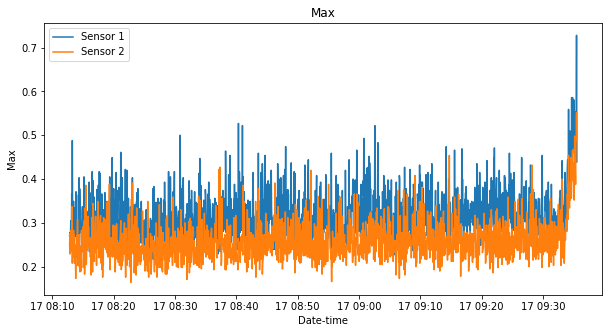

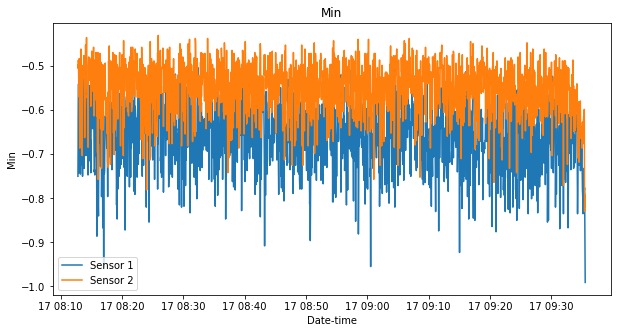

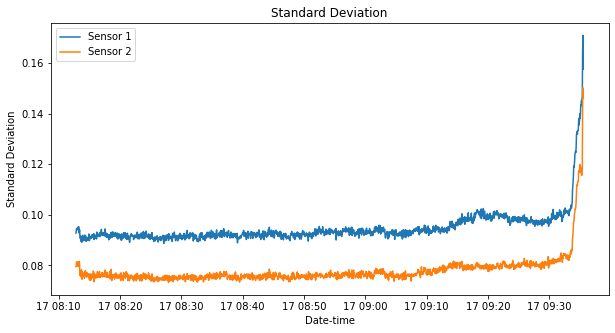

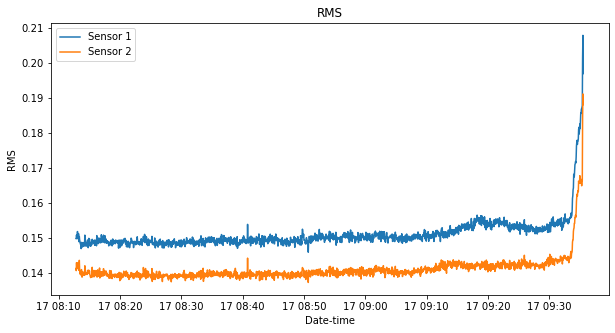

In [14]:
# Features of each sensor:
feature_s1= df_merged[['S1_max','S1_min','S1_std','S1_rms']]
feature_s2= df_merged[['S2_max','S2_min','S2_std','S2_rms']]

feature_s1.columns=['Max','Min','Standard Deviation','RMS']
feature_s2.columns=['Max','Min','Standard Deviation','RMS']

for i, col in enumerate(feature_s1.columns):

    plt.figure(figsize=(10,5))
    plt.plot(feature_df.index, feature_s1[col], label='Sensor 1')
    plt.plot(feature_df.index, feature_s2[col], label='Sensor 2')
    plt.legend()
    plt.xlabel('Date-time')
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [15]:
#Extract 20 Datapoints with 'quality' OK and nOK

clipped_features = df_merged.loc['2021-05-17 09:33:03': '2021-05-17 09:34:00', 'quality':'S2_rms']

features= clipped_features[['S1_max','S1_min','S1_mean','S1_std','S1_rms']]

ok_df = features.loc[clipped_features.quality=='OK', :]
nok_df =features.loc[clipped_features.quality=='nOK', :]

print(ok_df)

                     S1_max  S1_min   S1_mean    S1_std    S1_rms
timestamp                                                        
2021-05-17 09:33:03   0.361  -0.625 -0.117633  0.101540  0.155395
2021-05-17 09:33:06   0.315  -0.627 -0.116826  0.100295  0.153971
2021-05-17 09:33:09   0.442  -0.649 -0.117306  0.101224  0.154940
2021-05-17 09:33:12   0.366  -0.735 -0.117131  0.101113  0.154735
2021-05-17 09:33:15   0.337  -0.664 -0.117806  0.099663  0.154306
2021-05-17 09:33:21   0.264  -0.630 -0.117820  0.101453  0.155479
2021-05-17 09:33:30   0.249  -0.647 -0.117238  0.102366  0.155638
2021-05-17 09:33:42   0.325  -0.728 -0.116997  0.103833  0.156426
2021-05-17 09:33:45   0.303  -0.725 -0.118043  0.104957  0.157954
2021-05-17 09:33:48   0.283  -0.657 -0.118531  0.109313  0.161240


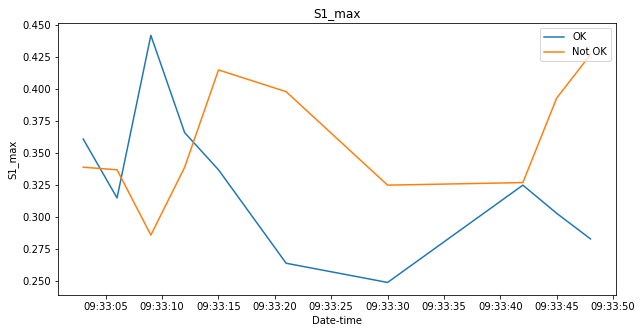

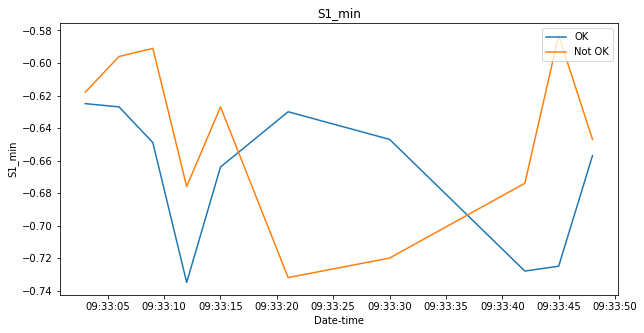

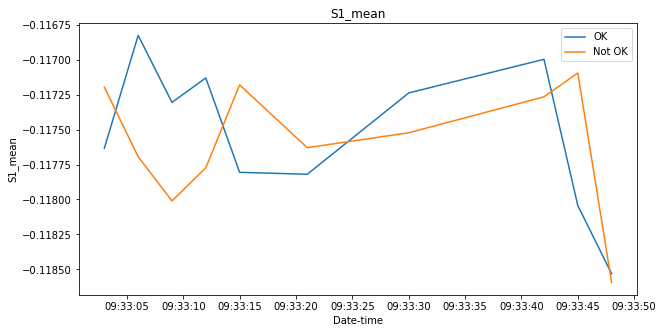

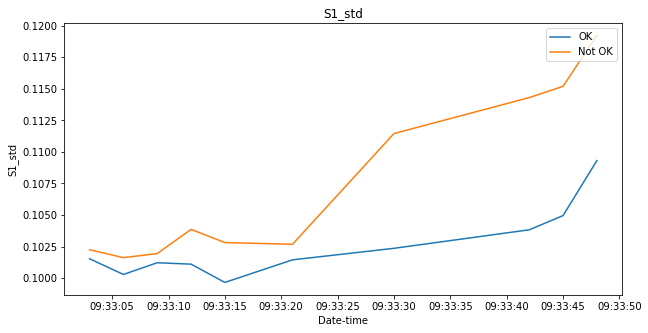

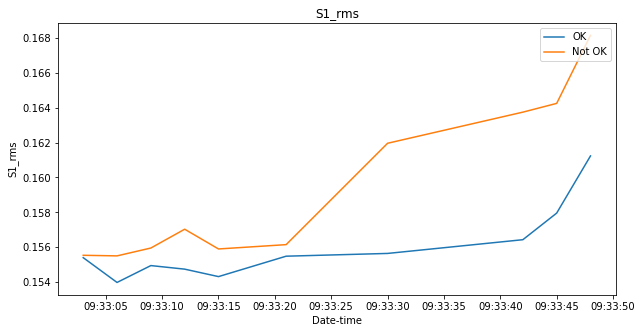

In [16]:
# visualization based on Quality
for i, col in enumerate(ok_df.columns):

    plt.figure(figsize=(10,5))
    plt.plot(ok_df.index, ok_df[col], label ='OK')
    plt.plot(ok_df.index, nok_df[col], label= 'Not OK')
    plt.legend(loc='upper right')
    plt.xlabel('Date-time')
    plt.ylabel(col)
    plt.title(col)
    plt.show()

1564


AttributeError: 'tuple' object has no attribute 'bar'

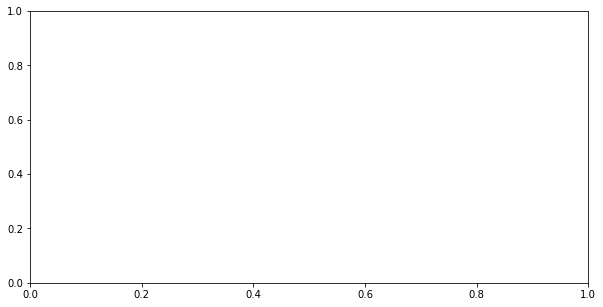

In [40]:
x_val= df_qual_log['quality'].value_counts()

ax2.b(x_val, label='quality')

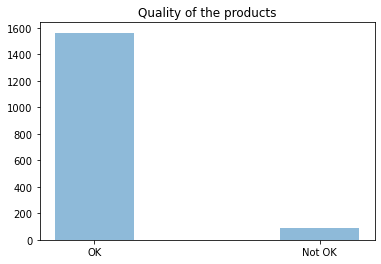

In [60]:

import mplcursors

objects = ['OK', 'Not OK']
y_Axis= [x_val['OK'],x_val['nOK']]

bar_Width= 0.35
plt.bar(y_pos,y_Axis,bar_Width, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Quality of the products')
mplcursors.cursor(hover=True)
plt.savefig('Quality.png',dpi='figure')
plt.show()




### Modelling and Evaluation

In [19]:
features_train = ['S1_max','S1_min','S1_mean','S1_std','S1_rms','S2_max','S2_min','S2_mean','S2_std','S2_rms']
X_features = df_merged[features_train].to_numpy()
Y = df_merged['quality'].to_numpy()

# Encode labels: "OK" - 1 "nOK" - 0

Y = np.where(Y == 'OK',1,0)

In [64]:
# Split the feature matrix intro test and train

X_train, X_test, Y_train, Y_test = train_test_split(X_features,Y,test_size = 0.30)

In [65]:
# Instantiate the Scaler and the Classifier

scaler = StandardScaler()
logreg = LogisticRegression( solver = 'liblinear', class_weight = 'balanced')

In [66]:
# IGNORE: Junk code
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# model.fit(X_train, Y_train)
# preds = model.predict(X_test)

In [67]:
#Instantiate a pipeline object with Scaler and Classifier 

pipe = Pipeline([('scaler',scaler),("classifier",logreg)])

In [68]:
# Fit the pipeline object

pipe.fit(X_train,Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

In [69]:
preds = pipe.predict(X_test)

In [74]:
# Should we use weighted average in metrics? It helps account for label imbalance

metrics.f1_score(Y_test, preds,average = 'weighted')

0.9110376544984191